In [20]:
import pandas as pd
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import xgboost as xgb
import optuna
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import multiprocessing as mp

In [21]:
df = pd.read_csv(r'C:\Users\leoqi\Desktop\NUS_Modules\DSE4211\DSE4211-Group-BTC-Day-Trading\data\processed\merged_df_with_signals.csv')

In [22]:
df.columns

Index(['datetime', 'reddit_smoothed_sentiment_weibull_week',
       'news_smoothed_sentiment_weibull_week',
       'tele_smoothed_sentiment_weibull_week', 'Open', 'High', 'Low', 'Close',
       'TOTAL_TRADES', 'TOTAL_TRADES_BUY', 'TOTAL_TRADES_SELL', 'VOLUME',
       'VOLUME_BUY', 'VOLUME_SELL', 'return', 'log_return',
       'hourly_volatility', 'EMA_8', 'EMA_13', 'EMA_21', 'EMA_Signal',
       'EMA_short', 'EMA_long', 'MACD', 'Signal_Line', 'MACD_Signal',
       'MACD_Hist', 'SMA20', 'STD20', 'Upper_BB', 'Lower_BB', 'RSI_14',
       'BB_RSI_Signal', 'RSI_Signal', 'SMA_50', 'SMA_200',
       'GoldenCross_Signal', '%K', '%D', 'Stochastic_Signal', 'OBV',
       'OBV_EMA20', 'OBV_Signal', 'H-L', 'H-PC', 'L-PC', 'TR', 'ATR',
       'reddit_sentiment_log', 'news_sentiment_log', 'tele_sentiment_log',
       'reddit_Signal', 'news_Signal', 'tele_Signal', 'typical_price', 'DATE',
       'VWAP', 'VWAP_Signal'],
      dtype='object')

In [23]:
base_price_data = ['datetime','Close','Open','High','Low','VOLUME']

technical_indicators = [
    # Trend Indicators
    'EMA_8', 'EMA_13', 'EMA_21', 'EMA_Signal', 'EMA_short', 'EMA_long',
    'SMA20', 'SMA_50', 'SMA_200', 'GoldenCross_Signal',

    # Momentum Indicators
    'MACD', 'Signal_Line', 'MACD_Signal', 'MACD_Hist',
    'RSI_14', 'BB_RSI_Signal', 'RSI_Signal',
    '%K', '%D', 'Stochastic_Signal',

    # Volatility Indicators
    'STD20', 'Upper_BB', 'Lower_BB', 'ATR', 'TR',

    # Volume-Based Indicators
    'OBV', 'OBV_EMA20', 'OBV_Signal', 'VWAP_Signal'
]

sentiment_indicators = [
    'reddit_sentiment_log',
    'tele_sentiment_log',
    'news_sentiment_log',
]

# Create a new DataFrame with the selected columns
selected_columns = base_price_data + technical_indicators + sentiment_indicators
df_selected = df[selected_columns]

In [24]:
df_selected

,datetime,Close,Open,High,Low,VOLUME,EMA_8,EMA_13,EMA_21,EMA_Signal,...,Lower_BB,ATR,TR,OBV,OBV_EMA20,OBV_Signal,VWAP_Signal,reddit_sentiment_log,tele_sentiment_log,news_sentiment_log
0,2024-01-27 13:00:00,41742.44,41750.00,41806.55,41725.21,419.38468,41729.550796,41714.525206,41617.761701,1,...,41524.488454,175.710000,81.34,-419.38468,-65.712408,0,-1,0.000000,2.060767,-6.755482
1,2024-01-27 14:00:00,41766.00,41742.44,41818.39,41731.01,493.43458,41737.650619,41721.878748,41631.237910,1,...,41541.267296,140.500000,87.38,493.43458,-12.460314,1,1,0.026643,2.060767,-6.766796
2,2024-01-27 15:00:00,41814.00,41766.00,41894.87,41733.60,581.25856,41754.617148,41735.038927,41647.852645,1,...,41561.147977,109.318333,161.27,581.25856,44.084341,0,1,0.152026,2.060767,-6.776304
3,2024-01-27 16:00:00,41810.18,41814.00,41895.74,41791.22,609.18361,41766.964449,41745.773366,41662.609678,1,...,41571.210298,101.921667,104.52,-609.18361,-18.131655,-1,1,0.262769,2.063227,-6.783594
4,2024-01-27 17:00:00,41779.28,41810.18,41845.34,41774.07,448.23397,41769.701238,41750.560028,41673.216071,1,...,41588.600128,99.801667,71.27,-448.23397,-59.093780,0,-1,0.361376,2.063227,-6.788139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10171,2025-03-26 08:00:00,87959.73,88140.45,88200.00,87886.10,525.11331,87756.884904,87689.841782,87613.211597,1,...,87158.682498,418.066667,313.90,-525.11331,59.670458,-1,1,-0.396829,2.601147,-3.780636
10172,2025-03-26 09:00:00,87939.99,87959.73,88056.61,87837.49,393.09750,87797.574925,87725.577241,87642.918724,1,...,87170.539414,392.118333,219.12,-393.09750,16.549700,0,1,-0.376302,2.601147,-3.692921
10173,2025-03-26 10:00:00,88208.47,87939.99,88259.81,87939.99,556.20541,87888.884942,87794.561921,87694.332477,1,...,87154.234720,378.148333,319.82,556.20541,67.945482,1,1,-0.356054,2.601147,-3.634124
10174,2025-03-26 11:00:00,87954.96,88208.47,88242.00,87923.91,940.31797,87903.568288,87817.475933,87718.025888,1,...,87155.773444,362.111667,318.09,-940.31797,-28.079609,-1,1,-0.336149,2.601147,-3.647040


In [25]:
df_selected['close_t+1'] = df_selected['Close'].shift(-1)
df_selected['close_t+2'] = df_selected['Close'].shift(-2)
df_selected['close_t+4'] = df_selected['Close'].shift(-4)
df_selected['close_t+8'] = df_selected['Close'].shift(-8)

C:\Users\leoqi\AppData\Local\Temp\ipykernel_259252\1322539743.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['close_t+1'] = df_selected['Close'].shift(-1)
C:\Users\leoqi\AppData\Local\Temp\ipykernel_259252\1322539743.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['close_t+2'] = df_selected['Close'].shift(-2)
C:\Users\leoqi\AppData\Local\Temp\ipykernel_259252\1322539743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [26]:
df_selected[['datetime','Close','close_t+1', 'close_t+2', 'close_t+4', 'close_t+8']].head(10)

,datetime,Close,close_t+1,close_t+2,close_t+4,close_t+8
0,2024-01-27 13:00:00,41742.44,41766.00,41814.00,41779.28,42150.59
1,2024-01-27 14:00:00,41766.00,41814.00,41810.18,41797.62,42155.51
2,2024-01-27 15:00:00,41814.00,41810.18,41779.28,41910.47,42120.63
3,2024-01-27 16:00:00,41810.18,41779.28,41797.62,42059.93,41990.85
4,2024-01-27 17:00:00,41779.28,41797.62,41910.47,42150.59,42100.00
5,2024-01-27 18:00:00,41797.62,41910.47,42059.93,42155.51,42102.22
6,2024-01-27 19:00:00,41910.47,42059.93,42150.59,42120.63,42231.83
7,2024-01-27 20:00:00,42059.93,42150.59,42155.51,41990.85,42720.32
8,2024-01-27 21:00:00,42150.59,42155.51,42120.63,42100.00,42562.44
9,2024-01-27 22:00:00,42155.51,42120.63,41990.85,42102.22,42413.27


In [27]:
df_selected

,datetime,Close,Open,High,Low,VOLUME,EMA_8,EMA_13,EMA_21,EMA_Signal,...,OBV_EMA20,OBV_Signal,VWAP_Signal,reddit_sentiment_log,tele_sentiment_log,news_sentiment_log,close_t+1,close_t+2,close_t+4,close_t+8
0,2024-01-27 13:00:00,41742.44,41750.00,41806.55,41725.21,419.38468,41729.550796,41714.525206,41617.761701,1,...,-65.712408,0,-1,0.000000,2.060767,-6.755482,41766.00,41814.00,41779.28,42150.59
1,2024-01-27 14:00:00,41766.00,41742.44,41818.39,41731.01,493.43458,41737.650619,41721.878748,41631.237910,1,...,-12.460314,1,1,0.026643,2.060767,-6.766796,41814.00,41810.18,41797.62,42155.51
2,2024-01-27 15:00:00,41814.00,41766.00,41894.87,41733.60,581.25856,41754.617148,41735.038927,41647.852645,1,...,44.084341,0,1,0.152026,2.060767,-6.776304,41810.18,41779.28,41910.47,42120.63
3,2024-01-27 16:00:00,41810.18,41814.00,41895.74,41791.22,609.18361,41766.964449,41745.773366,41662.609678,1,...,-18.131655,-1,1,0.262769,2.063227,-6.783594,41779.28,41797.62,42059.93,41990.85
4,2024-01-27 17:00:00,41779.28,41810.18,41845.34,41774.07,448.23397,41769.701238,41750.560028,41673.216071,1,...,-59.093780,0,-1,0.361376,2.063227,-6.788139,41797.62,41910.47,42150.59,42100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10171,2025-03-26 08:00:00,87959.73,88140.45,88200.00,87886.10,525.11331,87756.884904,87689.841782,87613.211597,1,...,59.670458,-1,1,-0.396829,2.601147,-3.780636,87939.99,88208.47,87813.17,NaN
10172,2025-03-26 09:00:00,87939.99,87959.73,88056.61,87837.49,393.09750,87797.574925,87725.577241,87642.918724,1,...,16.549700,0,1,-0.376302,2.601147,-3.692921,88208.47,87954.96,NaN,NaN
10173,2025-03-26 10:00:00,88208.47,87939.99,88259.81,87939.99,556.20541,87888.884942,87794.561921,87694.332477,1,...,67.945482,1,1,-0.356054,2.601147,-3.634124,87954.96,87813.17,NaN,NaN
10174,2025-03-26 11:00:00,87954.96,88208.47,88242.00,87923.91,940.31797,87903.568288,87817.475933,87718.025888,1,...,-28.079609,-1,1,-0.336149,2.601147,-3.647040,87813.17,NaN,NaN,NaN


In [28]:
df_selected.isna().sum()

datetime                0
Close                   0
Open                    0
High                    0
Low                     0
VOLUME                  0
EMA_8                   0
EMA_13                  0
EMA_21                  0
EMA_Signal              0
EMA_short               0
EMA_long                0
SMA20                   0
SMA_50                  0
SMA_200                 0
GoldenCross_Signal      0
MACD                    0
Signal_Line             0
MACD_Signal             0
MACD_Hist               0
RSI_14                  0
BB_RSI_Signal           0
RSI_Signal              0
%K                      0
%D                      0
Stochastic_Signal       0
STD20                   0
Upper_BB                0
Lower_BB                0
ATR                     0
TR                      0
OBV                     0
OBV_EMA20               0
OBV_Signal              0
VWAP_Signal             0
reddit_sentiment_log    0
tele_sentiment_log      0
news_sentiment_log      0
close_t+1   

In [29]:
df_selected = df_selected.dropna()

In [30]:
df_copy = df_selected.copy()

In [31]:
def sequencing_data(df, window_size=6):
    def process_grouped(group):
        samples = pd.DataFrame()
        group = group.reset_index(drop=True)

        for idx in group.index[window_size:]:
            sample = {}
            past_data = group.loc[idx - window_size:idx]

            # Timestamp
            inference_date = group.iloc[idx]['datetime']

            # Past Features
            past_features = {
                'past_close': list(past_data['Close']),
                'past_high': list(past_data['High']),
                'past_low': list(past_data['Low']),
                'past_volume': list(past_data['VOLUME'])
            }

            # Technical Indicators
            for indicator in [
                'EMA_8', 'EMA_13', 'EMA_21', 'EMA_Signal', 'EMA_short', 'EMA_long',
                'SMA20', 'SMA_50', 'SMA_200', 'GoldenCross_Signal',
                'MACD', 'Signal_Line', 'MACD_Signal', 'MACD_Hist',
                'RSI_14', 'BB_RSI_Signal', 'RSI_Signal',
                '%K', '%D', 'Stochastic_Signal',
                'STD20', 'Upper_BB', 'Lower_BB', 'ATR', 'TR',
                'OBV', 'OBV_EMA20', 'OBV_Signal', 'VWAP_Signal'
            ]:
                past_features[f'past_{indicator}'] = list(past_data[indicator])

            # Sentiment Indicators
            for sentiment in ['reddit_sentiment_log', 'tele_sentiment_log', 'news_sentiment_log']:
                past_features[f'past_{sentiment}'] = list(past_data[sentiment])

            # Target
            target = [
                group.iloc[idx]['close_t+1'],
                group.iloc[idx]['close_t+2'],
                group.iloc[idx]['close_t+4'],
                group.iloc[idx]['close_t+8']
            ]

            sample = {'inference_date': inference_date, **past_features, 'target': target}
            samples = pd.concat([samples, pd.DataFrame([sample])], ignore_index=True)

        return samples

    # Process the data without grouping, just directly use the DataFrame
    samples = process_grouped(df)

    return samples

In [32]:

class FinDataset(Dataset):

    def __init__(self, frame, look_back_window, look_ahead_window, transform=None):
        self.frame = frame
        self.look_back_window = look_back_window
        self.look_ahead_window = look_ahead_window

        if look_back_window <= 0:
            raise ValueError("Please specify a valid timeframe of data to train on")

        # if look_ahead_window <= 0:
        #     raise ValueError("Please choose a valid h for h-step-ahead-forecast")

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        data = self.frame.iloc[idx]

        look_back_idx = self.look_back_window 
        look_ahead_idx = self.look_ahead_window

        # Basic features
        past_close = np.array(data['past_close'][-look_back_idx:])
        past_high = np.array(data['past_high'][-look_back_idx:])
        past_low = np.array(data['past_low'][-look_back_idx:])
        past_volume = np.array(data['past_volume'][-look_back_idx:])
        basic = np.concatenate([past_close,past_high, past_low,past_volume])

        # Technical indicators
        technical_indicators = [
            'EMA_8', 'EMA_13', 'EMA_21', 'EMA_Signal', 'EMA_short', 'EMA_long',
            'SMA20', 'SMA_50', 'SMA_200', 'GoldenCross_Signal',
            'MACD', 'Signal_Line', 'MACD_Signal', 'MACD_Hist',
            'RSI_14', 'BB_RSI_Signal', 'RSI_Signal',
            '%K', '%D', 'Stochastic_Signal',
            'STD20', 'Upper_BB', 'Lower_BB', 'ATR', 'TR',
            'OBV', 'OBV_EMA20', 'OBV_Signal', 'VWAP_Signal'
        ]
        
        technical_features = []
        for indicator in technical_indicators:
            technical_features.append(np.array(data[f'past_{indicator}'][-look_back_idx:]))
        technical = np.concatenate(technical_features)

        # Sentiment indicators
        sentiment_indicators = [
            'reddit_sentiment_log', 'tele_sentiment_log', 'news_sentiment_log'
        ]
        
        sentiment_features = []
        for sentiment in sentiment_indicators:
            sentiment_features.append(np.array(data[f'past_{sentiment}'][-look_back_idx:]))
        sentiment = np.concatenate(sentiment_features)

        # Full inputs
        inputs = np.concatenate([basic, technical, sentiment])

        # Target (next 4 closes)
        target = data['target']

        return np.float32(inputs), np.float32(target)


In [33]:
sequenced = sequencing_data(df_copy,window_size = 6)

In [34]:
df_copy[
    (pd.to_datetime(df_copy['datetime']) >= pd.Timestamp('2024-01-27 13:00:00')) & 
    (pd.to_datetime(df_copy['datetime']) <= pd.Timestamp('2024-01-27 19:00:00'))
]['High']

0    41806.55
1    41818.39
2    41894.87
3    41895.74
4    41845.34
5    41817.64
6    41986.06
Name: High, dtype: float64

In [35]:
df_copy[
    (pd.to_datetime(df_copy['datetime']) >= pd.Timestamp('2024-01-27 13:00:00')) & 
    (pd.to_datetime(df_copy['datetime']) <= pd.Timestamp('2024-01-27 20:00:00'))
]['High']

0    41806.55
1    41818.39
2    41894.87
3    41895.74
4    41845.34
5    41817.64
6    41986.06
7    42076.70
Name: High, dtype: float64

In [36]:
df_copy[pd.to_datetime(df_copy['datetime']) == pd.Timestamp('2024-01-27 20:00:00')]

,datetime,Close,Open,High,Low,VOLUME,EMA_8,EMA_13,EMA_21,EMA_Signal,...,OBV_EMA20,OBV_Signal,VWAP_Signal,reddit_sentiment_log,tele_sentiment_log,news_sentiment_log,close_t+1,close_t+2,close_t+4,close_t+8
7,2024-01-27 20:00:00,42059.93,41910.47,42076.7,41910.47,664.97501,41862.280061,41819.27579,41737.326296,1,...,119.639541,0,1,0.600731,2.063227,-6.796186,42150.59,42155.51,41990.85,42720.32


In [37]:
df_copy[pd.to_datetime(df_copy['datetime']) == pd.Timestamp('2024-01-27 21:00:00')]

,datetime,Close,Open,High,Low,VOLUME,EMA_8,EMA_13,EMA_21,EMA_Signal,...,OBV_EMA20,OBV_Signal,VWAP_Signal,reddit_sentiment_log,tele_sentiment_log,news_sentiment_log,close_t+1,close_t+2,close_t+4,close_t+8
8,2024-01-27 21:00:00,42150.59,42059.93,42176.47,42022.92,746.05127,41926.348936,41866.606392,41774.895724,1,...,179.297801,0,1,0.66541,2.063227,-6.793503,42155.51,42120.63,42100.0,42562.44


In [38]:
sequenced

,inference_date,past_close,past_high,past_low,past_volume,past_EMA_8,past_EMA_13,past_EMA_21,past_EMA_Signal,past_EMA_short,...,past_ATR,past_TR,past_OBV,past_OBV_EMA20,past_OBV_Signal,past_VWAP_Signal,past_reddit_sentiment_log,past_tele_sentiment_log,past_news_sentiment_log,target
0,2024-01-27 19:00:00,"[41742.44, 41766.0, 41814.0, 41810.18, 41779.2...","[41806.55, 41818.39, 41894.87, 41895.74, 41845...","[41725.21, 41731.01, 41733.6, 41791.22, 41774....","[419.38468, 493.43458, 581.25856, 609.18361, 4...","[41729.55079583185, 41737.650618980326, 41754....","[41714.52520589108, 41721.87874790664, 41735.0...","[41617.7617009544, 41631.23790995855, 41647.85...","[1, 1, 1, 1, 1, 1, 1]","[41720.54130165787, 41727.534947556655, 41740....",...,"[175.71000000000154, 140.50000000000122, 109.3...","[81.34000000000378, 87.37999999999738, 161.270...","[-419.38468, 493.43458, 581.25856, -609.18361,...","[-65.71240799305417, -12.460313898477589, 44.0...","[0, 1, 0, -1, 0, 1, 0]","[-1, 1, 1, 1, -1, 1, 1]","[0.0, 0.0266425795623465, 0.152026036471607, 0...","[2.060767095239432, 2.060767095239432, 2.06076...","[-6.755482399542175, -6.766795995954805, -6.77...","[42059.93, 42150.59, 42120.63, 42231.83]"
1,2024-01-27 20:00:00,"[41766.0, 41814.0, 41810.18, 41779.28, 41797.6...","[41818.39, 41894.87, 41895.74, 41845.34, 41817...","[41731.01, 41733.6, 41791.22, 41774.07, 41745....","[493.43458, 581.25856, 609.18361, 448.23397, 3...","[41737.650618980326, 41754.61714809581, 41766....","[41721.87874790664, 41735.03892677712, 41745.7...","[41631.23790995855, 41647.85264541686, 41662.6...","[1, 1, 1, 1, 1, 1, 1]","[41727.534947556655, 41740.83726331717, 41751....",...,"[140.50000000000122, 109.31833333333512, 101.9...","[87.37999999999738, 161.27000000000407, 104.51...","[493.43458, 581.25856, -609.18361, -448.23397,...","[-12.460313898477589, 44.08434075852027, -18.1...","[1, 0, -1, 0, 1, 0, 0]","[1, 1, 1, -1, 1, 1, 1]","[0.0266425795623465, 0.152026036471607, 0.2627...","[2.060767095239432, 2.060767095239432, 2.06322...","[-6.766795995954805, -6.776304427268962, -6.78...","[42150.59, 42155.51, 41990.85, 42720.32]"
2,2024-01-27 21:00:00,"[41814.0, 41810.18, 41779.28, 41797.62, 41910....","[41894.87, 41895.74, 41845.34, 41817.64, 41986...","[41733.6, 41791.22, 41774.07, 41745.26, 41790....","[581.25856, 609.18361, 448.23397, 392.55791, 8...","[41754.61714809581, 41766.96444851896, 41769.7...","[41735.03892677712, 41745.77336580896, 41750.5...","[41647.85264541686, 41662.60967765169, 41673.2...","[1, 1, 1, 1, 1, 1, 1]","[41740.83726331717, 41751.50537665299, 41755.7...",...,"[109.31833333333512, 101.92166666666768, 99.80...","[161.27000000000407, 104.5199999999968, 71.269...","[581.25856, -609.18361, -448.23397, 392.55791,...","[44.08434075852027, -18.131654551815, -59.0937...","[0, -1, 0, 1, 0, 0, 0]","[1, 1, -1, 1, 1, 1, 1]","[0.152026036471607, 0.2627692568272025, 0.3613...","[2.060767095239432, 2.063227001489746, 2.06322...","[-6.776304427268962, -6.783593745345505, -6.78...","[42155.51, 42120.63, 42100.0, 42562.44]"
3,2024-01-27 22:00:00,"[41810.18, 41779.28, 41797.62, 41910.47, 42059...","[41895.74, 41845.34, 41817.64, 41986.06, 42076...","[41791.22, 41774.07, 41745.26, 41790.87, 41910...","[609.18361, 448.23397, 392.55791, 806.22964, 6...","[41766.96444851896, 41769.70123773697, 41775.9...","[41745.77336580896, 41750.56002783625, 41757.2...","[41662.60967765169, 41673.21607059245, 41684.5...","[1, 1, 1, 1, 1, 1, 1]","[41751.50537665299, 41755.77839562945, 41762.2...",...,"[101.92166666666768, 99.80166666666628, 96.359...","[104.5199999999968, 71.2699999999968, 72.37999...","[-609.18361, -448.23397, 392.55791, 806.22964,...","[-18.131654551815, -59.093779832594514, -16.07...","[-1, 0, 1, 0, 0, 0, 0]","[1, -1, 1, 1, 1, 1, 1]","[0.2627692568272025, 0.3613759079017221, 0.449...","[2.063227001489746, 2.063227001489746, 2.06322...","[-6.783593745345505, -6.788138502412967, -6.79...","[42120.63, 41990.85, 42102.22, 42413.27]"
4,2024-01-27 23:00:00,"[4

In [44]:
sequenced['past_high'][0]

[41806.55, 41818.39, 41894.87, 41895.74, 41845.34, 41817.64, 41986.06]

In [39]:
sequenced.columns

Index(['inference_date', 'past_close', 'past_high', 'past_low', 'past_volume',
       'past_EMA_8', 'past_EMA_13', 'past_EMA_21', 'past_EMA_Signal',
       'past_EMA_short', 'past_EMA_long', 'past_SMA20', 'past_SMA_50',
       'past_SMA_200', 'past_GoldenCross_Signal', 'past_MACD',
       'past_Signal_Line', 'past_MACD_Signal', 'past_MACD_Hist', 'past_RSI_14',
       'past_BB_RSI_Signal', 'past_RSI_Signal', 'past_%K', 'past_%D',
       'past_Stochastic_Signal', 'past_STD20', 'past_Upper_BB',
       'past_Lower_BB', 'past_ATR', 'past_TR', 'past_OBV', 'past_OBV_EMA20',
       'past_OBV_Signal', 'past_VWAP_Signal', 'past_reddit_sentiment_log',
       'past_tele_sentiment_log', 'past_news_sentiment_log', 'target'],
      dtype='object')

In [40]:
print("Available Workers:", mp.cpu_count())

Available Workers: 24


In [45]:
dataset = FinDataset(sequenced,7,0)
dataloader = DataLoader(dataset,batch_size = 256 ,shuffle = False)
inputs = None
outputs = None
for i, (x, y) in enumerate(dataloader):
    if inputs is None:
        inputs = x  # Initialize inputs with the shape of x
        outputs = y  # Initialize outputs with the shape of y
    else:
        inputs = np.concatenate([inputs, x])
        outputs = np.concatenate([outputs, y])

In [46]:
inputs.shape, outputs.shape

((10162, 252), (10162, 4))

In [47]:
labels =sequenced [['inference_date']]

In [48]:
labels.to_parquet(f'../data/processed/labels_btc.parquet', index=False)

np.save(f'../data/processed/inputs_btc.npy',inputs)

np.save(f'../data/processed/outputs_btc.npy',outputs)

In [49]:
labels = pd.read_parquet(f'../data/processed/labels_btc.parquet')
inputs = np.load(f'../data/processed/inputs_btc.npy')


In [50]:
test = pd.concat([labels, pd.DataFrame(inputs.tolist())], axis=1)
test

,inference_date,0,1,2,3,4,5,6,7,8,...,242,243,244,245,246,247,248,249,250,251
0,2024-01-27 19:00:00,41742.441406,41766.000000,41814.000000,41810.179688,41779.281250,41797.621094,41910.468750,41806.550781,41818.390625,...,2.063227,2.063227,2.063227,-6.755482,-6.766796,-6.776304,-6.783594,-6.788138,-6.792672,-6.795299
1,2024-01-27 20:00:00,41766.000000,41814.000000,41810.179688,41779.281250,41797.621094,41910.468750,42059.929688,41818.390625,41894.871094,...,2.063227,2.063227,2.063227,-6.766796,-6.776304,-6.783594,-6.788138,-6.792672,-6.795299,-6.796185
2,2024-01-27 21:00:00,41814.000000,41810.179688,41779.281250,41797.621094,41910.468750,42059.929688,42150.589844,41894.871094,41895.738281,...,2.063227,2.063227,2.063227,-6.776304,-6.783594,-6.788138,-6.792672,-6.795299,-6.796185,-6.793503
3,2024-01-27 22:00:00,41810.179688,41779.281250,41797.621094,41910.468750,42059.929688,42150.589844,42155.511719,41895.738281,41845.339844,...,2.063227,2.063227,2.063227,-6.783594,-6.788138,-6.792672,-6.795299,-6.796185,-6.793503,-6.785344
4,2024-01-27 23:00:00,41779.281250,41797.621094,41910.468750,42059.929688,42150.589844,42155.511719,42120.628906,41845.339844,41817.640625,...,2.063227,2.063227,2.063227,-6.788138,-6.792672,-6.795299,-6.796185,-6.793503,-6.785344,-6.774743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10157,2025-03-26 00:00:00,87822.000000,88116.226562,87849.976562,87746.000000,87464.726562,87392.867188,87652.000000,88059.992188,88250.000000,...,2.626320,2.626320,2.626320,-5.731708,-5.670835,-5.598145,-5.505837,-5.400253,-5.286304,-5.168123
10158,2025-03-26 01:00:00,88116.226562,87849.976562,87746.000000,87464.726562,87392.867188,87652.000000,87836.039062,88250.000000,88539.632812,...,2.626320,2.626320,2.626320,-5.670835,-5.598145,-5.505837,-5.400253,-5.286304,-5.168123,-5.034676
10159,2025-03-26 02:00:00,87849.976562,87746.000000,87464.726562,87392.867188,87652.000000,87836.039062,87324.601562,88539.632812,88198.117188,...,2.626320,2.626320,2.626320,-5.598145,-5.505837,-5.400253,-5.286304,-5.168123,-5.034676,-4.885554
10160,2025-03-26 03:00:00,87746.000000,87464.726562,87392.867188,87652.000000,87836.039062,87324.601562,87153.507812,88198.117188,87805.820312,...,2.626320,2.626320,2.626320,-5.505837,-5.400253,-5.286304,-5.168123,-5.034676,-4.885554,-4.714509


In [51]:
labels[(labels['inference_date'] >= '2025-01-01') & (labels['inference_date'] < '2025-03-01')]

,inference_date
8141,2025-01-01 00:00:00
8142,2025-01-01 01:00:00
8143,2025-01-01 02:00:00
8144,2025-01-01 03:00:00
8145,2025-01-01 04:00:00
...,...
9552,2025-02-28 19:00:00
9553,2025-02-28 20:00:00
9554,2025-02-28 21:00:00
9555,2025-02-28 22:00:00


In [60]:
test[:8141]

,inference_date,0,1,2,3,4,5,6,7,8,...,242,243,244,245,246,247,248,249,250,251
0,2024-01-27 19:00:00,41742.441406,41766.000000,41814.000000,41810.179688,41779.281250,41797.621094,41910.468750,41806.550781,41818.390625,...,2.063227,2.063227,2.063227,-6.755482,-6.766796,-6.776304,-6.783594,-6.788138,-6.792672,-6.795299
1,2024-01-27 20:00:00,41766.000000,41814.000000,41810.179688,41779.281250,41797.621094,41910.468750,42059.929688,41818.390625,41894.871094,...,2.063227,2.063227,2.063227,-6.766796,-6.776304,-6.783594,-6.788138,-6.792672,-6.795299,-6.796185
2,2024-01-27 21:00:00,41814.000000,41810.179688,41779.281250,41797.621094,41910.468750,42059.929688,42150.589844,41894.871094,41895.738281,...,2.063227,2.063227,2.063227,-6.776304,-6.783594,-6.788138,-6.792672,-6.795299,-6.796185,-6.793503
3,2024-01-27 22:00:00,41810.179688,41779.281250,41797.621094,41910.468750,42059.929688,42150.589844,42155.511719,41895.738281,41845.339844,...,2.063227,2.063227,2.063227,-6.783594,-6.788138,-6.792672,-6.795299,-6.796185,-6.793503,-6.785344
4,2024-01-27 23:00:00,41779.281250,41797.621094,41910.468750,42059.929688,42150.589844,42155.511719,42120.628906,41845.339844,41817.640625,...,2.063227,2.063227,2.063227,-6.788138,-6.792672,-6.795299,-6.796185,-6.793503,-6.785344,-6.774743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8136,2024-12-31 19:00:00,95587.117188,95679.171875,95412.000000,94868.421875,94120.937500,93875.679688,94166.882812,96054.789062,96250.000000,...,1.968432,1.968432,2.029984,-6.291090,-6.313196,-6.335702,-6.357376,-6.382596,-6.413588,-6.449630
8137,2024-12-31 20:00:00,95679.171875,95412.000000,94868.421875,94120.937500,93875.679688,94166.882812,93564.039062,96250.000000,95982.617188,...,1.968432,2.029984,2.029984,-6.313196,-6.335702,-6.357376,-6.382596,-6.413588,-6.449630,-6.482636
8138,2024-12-31 21:00:00,95412.000000,94868.421875,94120.937500,93875.679688,94166.882812,93564.039062,93899.679688,95982.617188,95590.523438,...,2.029984,2.029984,2.029984,-6.335702,-6.357376,-6.382596,-6.413588,-6.449630,-6.482636,-6.514657
8139,2024-12-31 22:00:00,94868.421875,94120.937500,93875.679688,94166.882812,93564.039062,93899.679688,93488.843750,95590.523438,95047.710938,...,2.029984,2.029984,2.029984,-6.357376,-6.382596,-6.413588,-6.449630,-6.482636,-6.514657,-6.543260


In [58]:
test[8141:9557]

,inference_date,0,1,2,3,4,5,6,7,8,...,242,243,244,245,246,247,248,249,250,251
8141,2025-01-01 00:00:00,93875.679688,94166.882812,93564.039062,93899.679688,93488.843750,93576.000000,94401.140625,94416.718750,94290.906250,...,2.029984,2.029984,2.029984,-6.413588,-6.449630,-6.482636,-6.514657,-6.543260,-6.566459,-6.587146
8142,2025-01-01 01:00:00,94166.882812,93564.039062,93899.679688,93488.843750,93576.000000,94401.140625,93607.742188,94290.906250,94222.500000,...,2.029984,2.029984,2.029984,-6.449630,-6.482636,-6.514657,-6.543260,-6.566459,-6.587146,-6.607708
8143,2025-01-01 02:00:00,93564.039062,93899.679688,93488.843750,93576.000000,94401.140625,93607.742188,94098.906250,94222.500000,93964.148438,...,2.029984,2.029984,2.029984,-6.482636,-6.514657,-6.543260,-6.566459,-6.587146,-6.607708,-6.627062
8144,2025-01-01 03:00:00,93899.679688,93488.843750,93576.000000,94401.140625,93607.742188,94098.906250,93838.039062,93964.148438,93899.679688,...,2.029984,2.029984,2.029984,-6.514657,-6.543260,-6.566459,-6.587146,-6.607708,-6.627062,-6.644706
8145,2025-01-01 04:00:00,93488.843750,93576.000000,94401.140625,93607.742188,94098.906250,93838.039062,93553.906250,93899.679688,93756.000000,...,2.029984,2.029984,2.029984,-6.543260,-6.566459,-6.587146,-6.607708,-6.627062,-6.644706,-6.659000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9552,2025-02-28 19:00:00,81512.421875,82105.046875,84005.046875,84363.687500,83605.117188,84440.968750,84449.992188,81764.937500,82549.468750,...,0.911982,0.913890,0.913890,-8.410402,-8.408504,-8.406255,-8.404077,-8.401963,-8.399598,-8.396762
9553,2025-02-28 20:00:00,82105.046875,84005.046875,84363.687500,83605.117188,84440.968750,84449.992188,84191.273438,82549.468750,84425.890625,...,0.913890,0.913890,0.913890,-8.408504,-8.406255,-8.404077,-8.401963,-8.399598,-8.396762,-8.393514
9554,2025-02-28 21:00:00,84005.046875,84363.687500,83605.117188,84440.968750,84449.992188,84191.273438,84258.367188,84425.890625,84920.000000,...,0.913890,0.913890,0.919505,-8.406255,-8.404077,-8.401963,-8.399598,-8.396762,-8.393514,-8.389415
9555,2025-02-28 22:00:00,84363.687500,83605.117188,84440.968750,84449.992188,84191.273438,84258.367188,84149.976562,84920.000000,84400.000000,...,0.913890,0.919505,0.865208,-8.404077,-8.401963,-8.399598,-8.396762,-8.393514,-8.389415,-8.383914


In [55]:
test.iloc[9557]

inference_date    2025-03-01 00:00:00
0                         84440.96875
1                        84449.992188
2                        84191.273438
3                        84258.367188
                         ...         
247                         -8.393514
248                         -8.389415
249                         -8.383914
250                         -8.377521
251                         -8.370549
Name: 9557, Length: 253, dtype: object

In [61]:
X_train, X_val,X_test = inputs[:8141], inputs[8141:9557], inputs[9557:]
y_train, y_val,y_test = outputs[:8141], outputs[8141:9557], outputs[9557:]

In [62]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(8141, 252) (8141, 4)
(1416, 252) (1416, 4)
(605, 252) (605, 4)


In [63]:
def objective(trial):
    # Define the hyperparameters
    param = {
        'objective': 'reg:squarederror',  # Regression task
        'eval_metric': 'rmse',
        'booster': 'gbtree',
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'lambda': trial.suggest_float('lambda', 1e-5, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-5, 1.0)
    }

    # Train the XGBoost model with the suggested hyperparameters
    model = xgb.XGBRegressor(**param)

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    preds = model.predict(X_val)

    # Calculate RMSE (Root Mean Squared Error) as evaluation metric
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse


In [64]:
# Optuna study to optimize hyperparameters
study = optuna.create_study(direction='minimize')  # Minimize the RMSE
study.optimize(objective, n_trials=100)

[I 2025-04-03 21:18:13,979] A new study created in memory with name: no-name-fa87ee3d-a59f-4af8-8386-34f8404986af
[I 2025-04-03 21:18:18,796] Trial 0 finished with value: 1578.4666610353227 and parameters: {'n_estimators': 230, 'max_depth': 5, 'learning_rate': 0.02122896371347869, 'subsample': 0.8823658569092254, 'colsample_bytree': 0.6990208457915453, 'gamma': 1.2047048835768792, 'min_child_weight': 4, 'lambda': 0.4826955304399127, 'alpha': 0.8124396445498354}. Best is trial 0 with value: 1578.4666610353227.
[I 2025-04-03 21:18:58,207] Trial 1 finished with value: 1585.9763554353515 and parameters: {'n_estimators': 340, 'max_depth': 9, 'learning_rate': 0.046478954125669235, 'subsample': 0.7731492362308507, 'colsample_bytree': 0.7786163587695931, 'gamma': 2.8101401988537633, 'min_child_weight': 2, 'lambda': 0.8784799961465366, 'alpha': 0.4877297579049855}. Best is trial 0 with value: 1578.4666610353227.
[I 2025-04-03 21:19:07,263] Trial 2 finished with value: 1656.0935963888032 and par

In [65]:
print("Best Hyperparameters:", study.best_params)

model = xgb.XGBRegressor(**study.best_params)
model.fit(X_train, y_train)

preds = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))
print("Val RMSE after Hyperparameter Tuning:", rmse)

Best Hyperparameters: {'n_estimators': 403, 'max_depth': 3, 'learning_rate': 0.016396281929215155, 'subsample': 0.8333847397494717, 'colsample_bytree': 0.9280590867971299, 'gamma': 0.46860974247007614, 'min_child_weight': 6, 'lambda': 0.46678686076191733, 'alpha': 0.5135652050120147}
Val RMSE after Hyperparameter Tuning: 1335.186035726857


In [66]:
model.save_model('xgboost_model.json')

In [67]:
time_periods = [f't{i}' for i in range(-6,1)] 

columns = []

# Loop through each feature column and label the 7 values
for col in sequenced.columns[~sequenced.columns.isin(['inference_date', 'target'])]:
    for i, period in enumerate(time_periods):
        columns.append(f'{col}_{period}')  # Create a new label for each of the 7 values

# Create a new DataFrame with the time period labels as columns
df_labeled = pd.DataFrame(columns=columns)

mapping = dict(enumerate(df_labeled.columns))
mapping

{0: 'past_close_t-6',
 1: 'past_close_t-5',
 2: 'past_close_t-4',
 3: 'past_close_t-3',
 4: 'past_close_t-2',
 5: 'past_close_t-1',
 6: 'past_close_t0',
 7: 'past_high_t-6',
 8: 'past_high_t-5',
 9: 'past_high_t-4',
 10: 'past_high_t-3',
 11: 'past_high_t-2',
 12: 'past_high_t-1',
 13: 'past_high_t0',
 14: 'past_low_t-6',
 15: 'past_low_t-5',
 16: 'past_low_t-4',
 17: 'past_low_t-3',
 18: 'past_low_t-2',
 19: 'past_low_t-1',
 20: 'past_low_t0',
 21: 'past_volume_t-6',
 22: 'past_volume_t-5',
 23: 'past_volume_t-4',
 24: 'past_volume_t-3',
 25: 'past_volume_t-2',
 26: 'past_volume_t-1',
 27: 'past_volume_t0',
 28: 'past_EMA_8_t-6',
 29: 'past_EMA_8_t-5',
 30: 'past_EMA_8_t-4',
 31: 'past_EMA_8_t-3',
 32: 'past_EMA_8_t-2',
 33: 'past_EMA_8_t-1',
 34: 'past_EMA_8_t0',
 35: 'past_EMA_13_t-6',
 36: 'past_EMA_13_t-5',
 37: 'past_EMA_13_t-4',
 38: 'past_EMA_13_t-3',
 39: 'past_EMA_13_t-2',
 40: 'past_EMA_13_t-1',
 41: 'past_EMA_13_t0',
 42: 'past_EMA_21_t-6',
 43: 'past_EMA_21_t-5',
 44: 'pas

<Axes: >

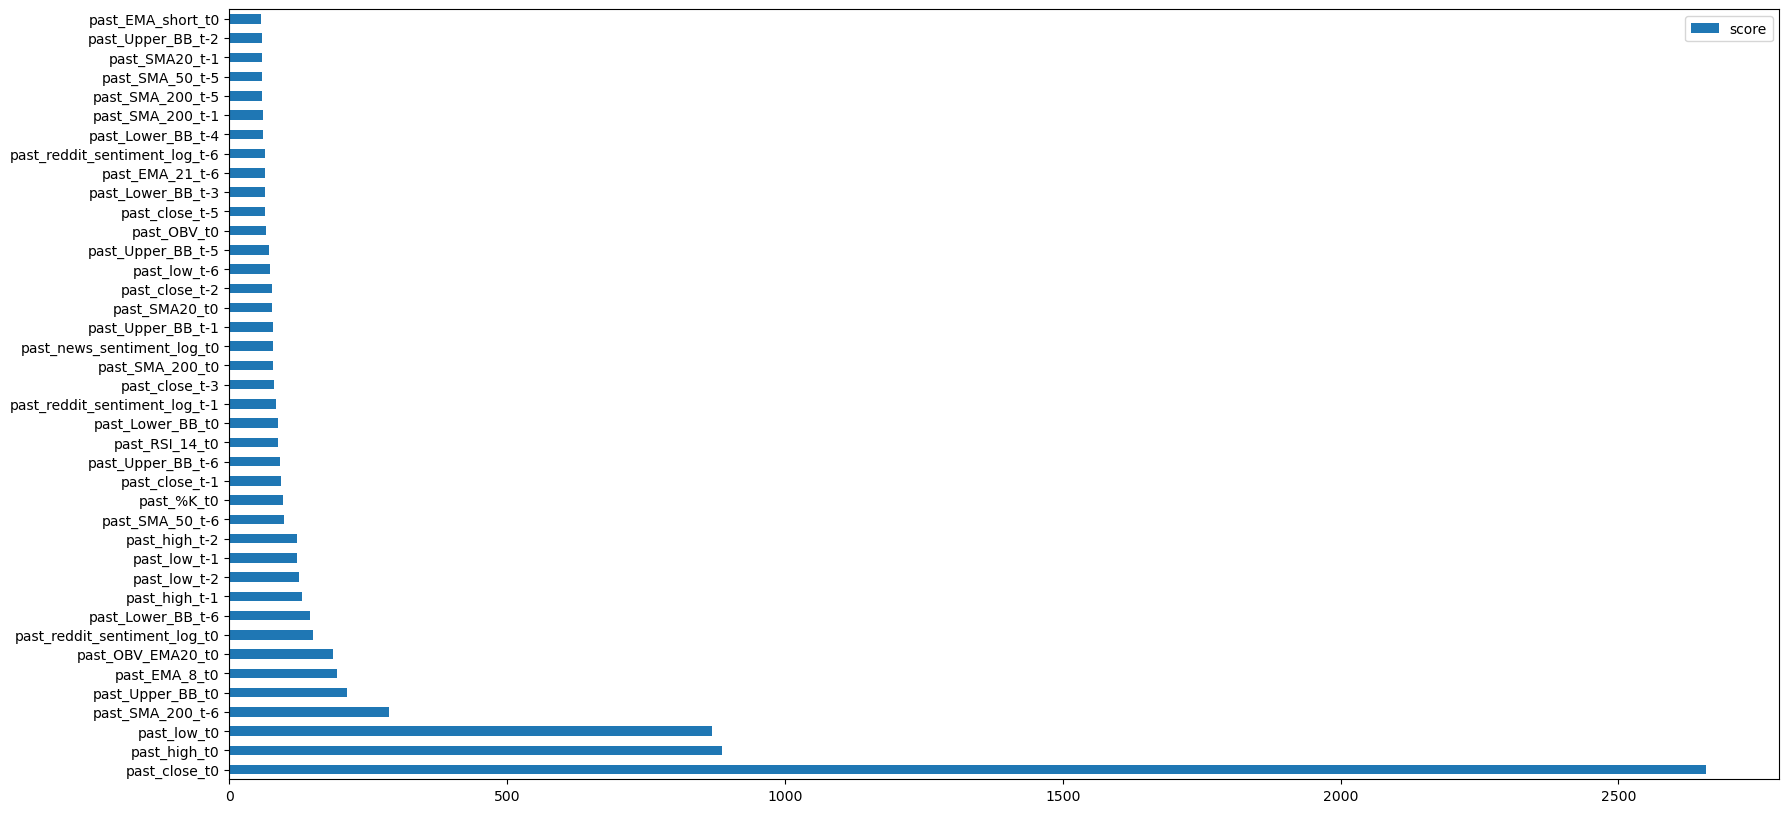

In [68]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

mapped_keys = [mapping[int(key[1:])] for key in keys]  

data = pd.DataFrame(data=values, index=mapped_keys , columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [69]:
#combined set X_train, y_train with X_val, y_val

X_combined = np.concatenate((X_train, X_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)

In [70]:
# Print the best hyperparameters
print("Best Hyperparameters:", study.best_params)

# Train the model with the best hyperparameters
best_model = xgb.XGBRegressor(**study.best_params)
best_model.fit(X_combined, y_combined)

# Evaluate the model on the test set
predictions = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Test RMSE after Hyperparameter Tuning:", rmse)

Best Hyperparameters: {'n_estimators': 403, 'max_depth': 3, 'learning_rate': 0.016396281929215155, 'subsample': 0.8333847397494717, 'colsample_bytree': 0.9280590867971299, 'gamma': 0.46860974247007614, 'min_child_weight': 6, 'lambda': 0.46678686076191733, 'alpha': 0.5135652050120147}
Test RMSE after Hyperparameter Tuning: 1448.8954413621434


In [71]:
best_model.save_model('xgboost_model_final.json')

In [72]:
y_test

array([[84656.93, 85240.46, 86190.01, 85303.37],
       [85240.46, 85330.84, 85588.19, 85380.  ],
       [85330.84, 86190.01, 85075.62, 84900.01],
       ...,
       [87153.51, 87326.78, 87909.07, 88208.47],
       [87326.78, 87520.35, 88140.45, 87954.96],
       [87520.35, 87909.07, 87959.73, 87813.17]],
      shape=(605, 4), dtype=float32)

In [73]:
predictions

array([[84083.766, 84074.52 , 84161.2  , 84167.26 ],
       [84095.1  , 84113.56 , 84183.664, 84097.65 ],
       [84093.055, 84120.82 , 84197.24 , 84047.03 ],
       ...,
       [87056.42 , 87346.98 , 87878.98 , 87697.445],
       [87031.35 , 87329.01 , 87856.98 , 87642.04 ],
       [87026.43 , 87331.195, 87870.62 , 87690.74 ]],
      shape=(605, 4), dtype=float32)

In [75]:
labels[labels['inference_date'] >= '2025-03-01']

,inference_date
9557,2025-03-01 00:00:00
9558,2025-03-01 01:00:00
9559,2025-03-01 02:00:00
9560,2025-03-01 03:00:00
9561,2025-03-01 04:00:00
...,...
10157,2025-03-26 00:00:00
10158,2025-03-26 01:00:00
10159,2025-03-26 02:00:00
10160,2025-03-26 03:00:00


In [76]:
a = df_copy[df_copy['datetime'] >= '2025-03-01'][['datetime', 'Close']].reset_index(drop=True)
a

,datetime,Close
0,2025-03-01 00:00:00,83857.92
1,2025-03-01 01:00:00,84656.93
2,2025-03-01 02:00:00,85240.46
3,2025-03-01 03:00:00,85330.84
4,2025-03-01 04:00:00,86190.01
...,...,...
600,2025-03-26 00:00:00,87652.00
601,2025-03-26 01:00:00,87836.04
602,2025-03-26 02:00:00,87324.60
603,2025-03-26 03:00:00,87153.51


In [77]:
y_test_df = pd.DataFrame(y_test, columns=['close_t+1', 'close_t+2', 'close_t+4', 'close_t+8']).reset_index(drop=True)
pred_df = pd.DataFrame(predictions, columns=['pred_close_t+1', 'pred_close_t+2', 'pred_close_t+4', 'pred_close_t+8']).reset_index(drop=True)

ab = pd.concat([a, y_test_df, pred_df], axis=1)
ab

,datetime,Close,close_t+1,close_t+2,close_t+4,close_t+8,pred_close_t+1,pred_close_t+2,pred_close_t+4,pred_close_t+8
0,2025-03-01 00:00:00,83857.92,84656.929688,85240.460938,86190.007812,85303.367188,84083.765625,84074.523438,84161.203125,84167.257812
1,2025-03-01 01:00:00,84656.93,85240.460938,85330.843750,85588.187500,85380.000000,84095.101562,84113.562500,84183.664062,84097.648438
2,2025-03-01 02:00:00,85240.46,85330.843750,86190.007812,85075.617188,84900.007812,84093.054688,84120.820312,84197.242188,84047.031250
3,2025-03-01 03:00:00,85330.84,86190.007812,85588.187500,84740.148438,84632.789062,84667.507812,84462.156250,84089.164062,83982.898438
4,2025-03-01 04:00:00,86190.01,85588.187500,85075.617188,85303.367188,84758.859375,86464.343750,86531.148438,86425.375000,86040.625000
...,...,...,...,...,...,...,...,...,...,...
600,2025-03-26 00:00:00,87652.00,87836.039062,87324.601562,87326.781250,87959.726562,87899.398438,88388.140625,88137.359375,87473.359375
601,2025-03-26 01:00:00,87836.04,87324.601562,87153.507812,87520.351562,87939.992188,87929.929688,88403.359375,88377.382812,87811.593750
602,2025-03-26 02:00:00,87324.60,87153.507812,87326.781250,87909.070312,88208.468750,87056.421875,87346.976562,87878.976562,87697.445312
603,2025-03-26 03:00:00,87153.51,87326.781250,87520.351562,88140.453125,87954.960938,87031.351562,87329.007812,87856.976562,87642.039062


In [78]:
def determine_signal_pred(row):
    # Count how many of the forecasted values are greater than the actual Close value
    positive_predictions = sum([
        row['pred_close_t+1'] > row['Close'],
        row['pred_close_t+2'] > row['Close'],
        row['pred_close_t+4'] > row['Close'],
        row['pred_close_t+8'] > row['Close']
    ])
    
    # If 3 or more predictions are greater than Close, return 1, else return 0
    return 1 if positive_predictions >= 3 else 0

def determine_signal_actual(row):
    # Count how many of the forecasted values are greater than the actual Close value
    positive_predictions = sum([
        row['close_t+1'] > row['Close'],
        row['close_t+2'] > row['Close'],
        row['close_t+4'] > row['Close'],
        row['close_t+8'] > row['Close']
    ])
    
    # If 3 or more predictions are greater than Close, return 1, else return 0
    return 1 if positive_predictions >= 3 else 0

In [79]:
ab['buy_pred_signal'] = ab.apply(determine_signal_pred, axis=1)
ab['buy_actual_signal'] = ab.apply(determine_signal_actual, axis=1)

In [80]:
ab

,datetime,Close,close_t+1,close_t+2,close_t+4,close_t+8,pred_close_t+1,pred_close_t+2,pred_close_t+4,pred_close_t+8,buy_pred_signal,buy_actual_signal
0,2025-03-01 00:00:00,83857.92,84656.929688,85240.460938,86190.007812,85303.367188,84083.765625,84074.523438,84161.203125,84167.257812,1,1
1,2025-03-01 01:00:00,84656.93,85240.460938,85330.843750,85588.187500,85380.000000,84095.101562,84113.562500,84183.664062,84097.648438,0,1
2,2025-03-01 02:00:00,85240.46,85330.843750,86190.007812,85075.617188,84900.007812,84093.054688,84120.820312,84197.242188,84047.031250,0,0
3,2025-03-01 03:00:00,85330.84,86190.007812,85588.187500,84740.148438,84632.789062,84667.507812,84462.156250,84089.164062,83982.898438,0,0
4,2025-03-01 04:00:00,86190.01,85588.187500,85075.617188,85303.367188,84758.859375,86464.343750,86531.148438,86425.375000,86040.625000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
600,2025-03-26 00:00:00,87652.00,87836.039062,87324.601562,87326.781250,87959.726562,87899.398438,88388.140625,88137.359375,87473.359375,1,0
601,2025-03-26 01:00:00,87836.04,87324.601562,87153.507812,87520.351562,87939.992188,87929.929688,88403.359375,88377.382812,87811.593750,1,0
602,2025-03-26 02:00:00,87324.60,87153.507812,87326.781250,87909.070312,88208.468750,87056.421875,87346.976562,87878.976562,87697.445312,1,1
603,2025-03-26 03:00:00,87153.51,87326.781250,87520.351562,88140.453125,87954.960938,87031.351562,87329.007812,87856.976562,87642.039062,1,1


In [81]:
number_of_actual_signals = ab['buy_actual_signal'].sum()
number_of_pred_signals = ab['buy_pred_signal'].sum()

print("Number of Actual Signals (1):", number_of_actual_signals)
print("Number of Predicted Signals (1):", number_of_pred_signals)

Number of Actual Signals (1): 268
Number of Predicted Signals (1): 346


In [82]:
def determine_signal_pred(row):
    # Count how many of the forecasted values are greater than the actual Close value
    negative_predictions = sum([
        row['pred_close_t+1'] < row['Close'],
        row['pred_close_t+2'] < row['Close'],
        row['pred_close_t+4'] < row['Close'],
        row['pred_close_t+8'] < row['Close']
    ])
    
    # If 3 or more predictions are greater than Close, return 1, else return 0
    return 1 if negative_predictions >= 3 else 0

def determine_signal_actual(row):
    # Count how many of the forecasted values are greater than the actual Close value
    negative_predictions = sum([
        row['close_t+1'] < row['Close'],
        row['close_t+2'] < row['Close'],
        row['close_t+4'] < row['Close'],
        row['close_t+8'] < row['Close']
    ])
    
    # If 3 or more predictions are greater than Close, return 1, else return 0
    return 1 if negative_predictions >= 3 else 0

In [83]:
ab['sell_pred_signal'] = ab.apply(determine_signal_pred, axis=1)
ab['sell_actual_signal'] = ab.apply(determine_signal_actual, axis=1)

In [84]:
number_of_actual_signals = ab['sell_actual_signal'].sum()
number_of_pred_signals = ab['sell_pred_signal'].sum()

print("Number of Actual Signals (1):", number_of_actual_signals)
print("Number of Predicted Signals (1):", number_of_pred_signals)

Number of Actual Signals (1): 233
Number of Predicted Signals (1): 234


In [85]:
buy_cm = confusion_matrix(ab['buy_actual_signal'], ab['buy_pred_signal'])
sell_cm = confusion_matrix(ab['sell_actual_signal'], ab['sell_pred_signal'])

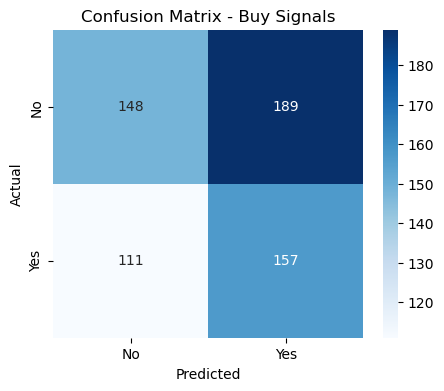

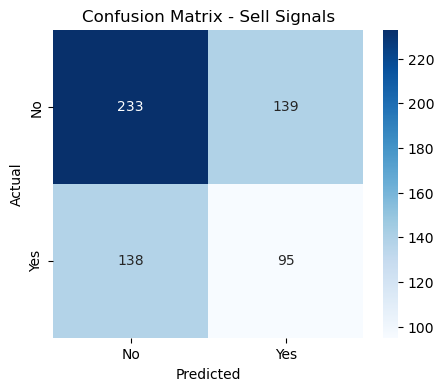

In [86]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(buy_cm, "Confusion Matrix - Buy Signals")
plot_confusion_matrix(sell_cm, "Confusion Matrix - Sell Signals")

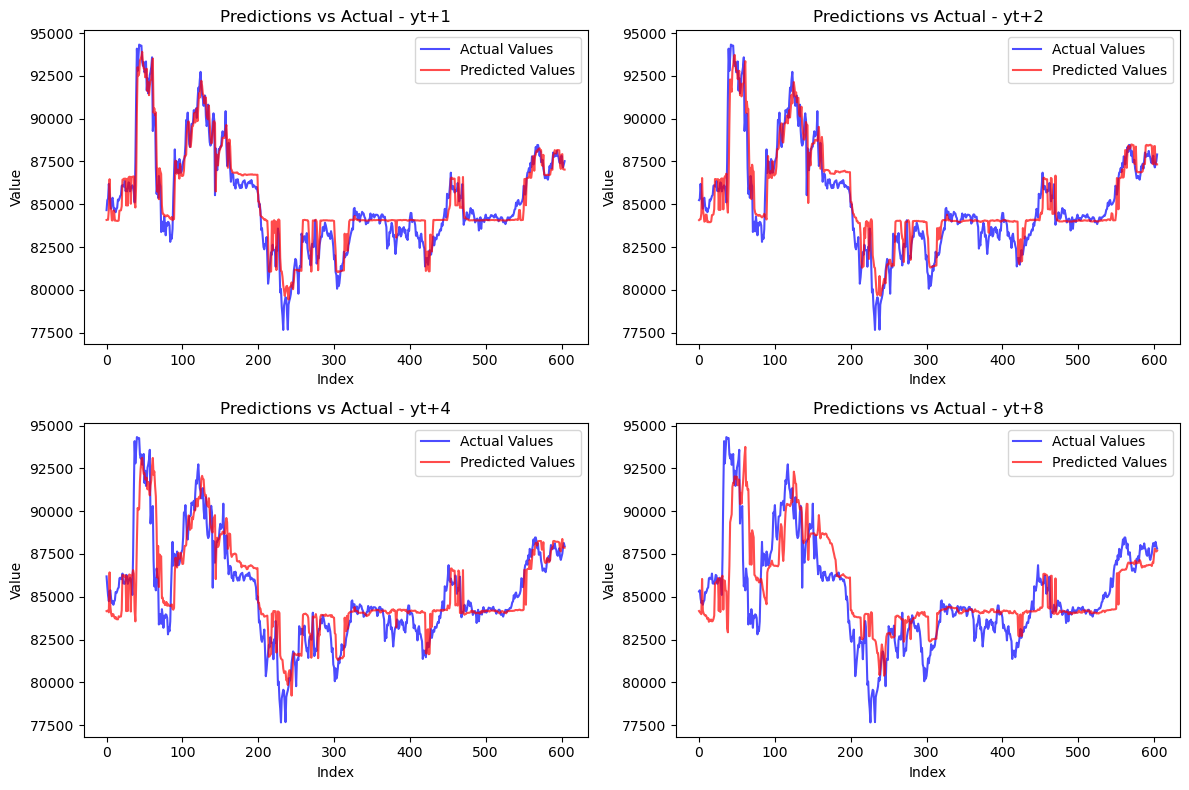

In [94]:
plt.figure(figsize=(12, 8))

titles = ['yt+1', 'yt+2', 'yt+4', 'yt+8']  # Titles for each subplot

for i in range(4):
    plt.subplot(2, 2, i+1)  # 2 rows, 2 columns, subplot for each
    plt.plot(y_test[:, i], label='Actual Values', color='blue', alpha=0.7)
    plt.plot(predictions[:, i], label='Predicted Values', color='red', alpha=0.7)
    plt.title(f'Predictions vs Actual - {titles[i]}')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()